In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


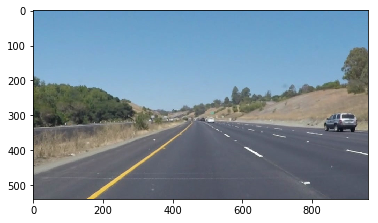

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
%matplotlib inline
plt.imshow(image)

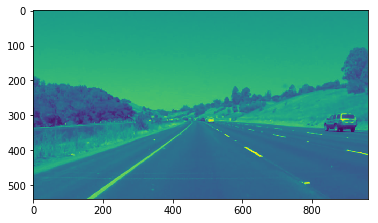

In [3]:
#grayscale the image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
plt.imshow(gray)

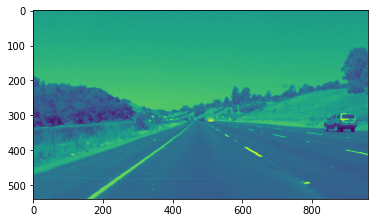

In [4]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
plt.imshow(blur_gray)

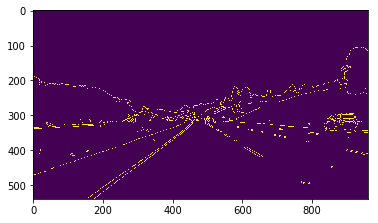

In [5]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges)

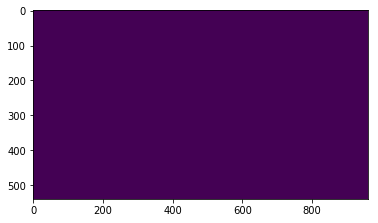

In [6]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255
plt.imshow(mask)

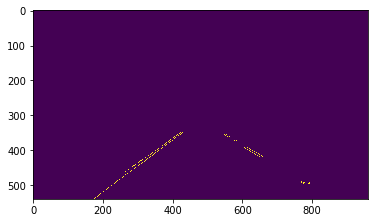

In [7]:
# This time we are defining a four sided polygon to mask
imshape = image.shape
y_top = 350
y_bottom = 539
vertices = np.array([[(170,y_bottom),(880,y_bottom),(650,y_top),(400,y_top)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges)

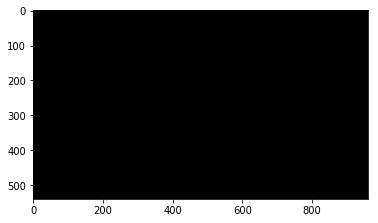

In [8]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 0.1 # distance resolution in pixels of the Hough grid
theta = np.pi/180/10 # angular resolution in radians of the Hough grid
threshold = 3     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on
plt.imshow(line_image)

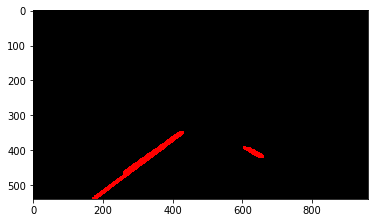

In [9]:
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
plt.imshow(line_image)

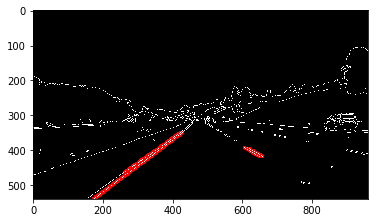

In [10]:
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges))
plt.imshow(color_edges)

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 2, line_image, 1, 0) 
plt.imshow(lines_edges)

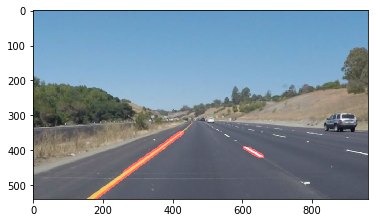

In [11]:
# Draw the lines on the original colored image
lines_color_edges = cv2.addWeighted(image, 1, line_image, 2, 0) 
plt.imshow(lines_color_edges)

[[618 395]
 [658 417]
 [605 393]
 [652 419]]
[[175 539]
 [427 350]
 [262 463]
 [418 353]
 [307 441]
 [428 350]
 [174 538]
 [287 454]
 [297 439]
 [388 375]
 [175 538]
 [302 443]
 [394 369]
 [422 350]
 [289 454]
 [349 409]
 [268 459]
 [294 441]]
[ 885.67792578  526.96455756]
[ 170.2910194   423.08087588]


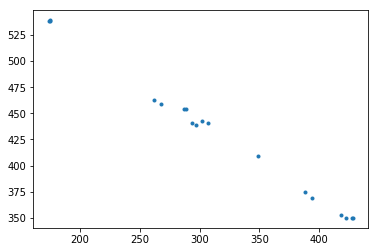

In [12]:
# Separate points between left and right lanes    
points_right = np.zeros((1,2),dtype=int)
points_left = np.zeros((1,2),dtype=int)
for line in lines:
    for x1,y1,x2,y2 in line:
        if (y2-y1)/(x2-x1) >= 0:
            points_right = np.concatenate((points_right,np.array([[x1, y1]])),axis=0)
            points_right = np.concatenate((points_right,np.array([[x2, y2]])),axis=0)
        else:
            points_left = np.concatenate((points_left,np.array([[x1, y1]])),axis=0)
            points_left = np.concatenate((points_left,np.array([[x2, y2]])),axis=0)
points_right = np.delete(points_right,0,0)
points_left = np.delete(points_left,0,0)

# Find best fit for both lanes
points_right_x = points_right[:,0]
points_right_y = points_right[:,1]
points_left_x = points_left[:,0]
points_left_y = points_left[:,1]

def linear_fit(x,y,y_ref):
    fit = np.polyfit(x,y,1)
    return (y_ref-fit[1])/fit[0]

lane_y = [y_bottom, y_top]
lane_right_x = linear_fit(points_right_x,points_right_y,lane_y)
lane_left_x = linear_fit(points_left_x,points_left_y,lane_y)

print(points_right)
print(points_left)
print(lane_right_x)
print(lane_left_x)
plt.plot(points_left[:,0],points_left[:,1],'.')

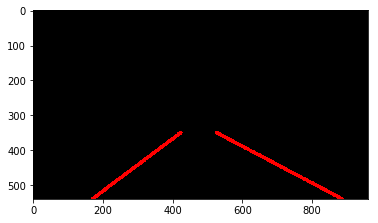

In [13]:
piped_image = np.copy(image)*0 # creating a blank to draw lines on

# Draw line
cv2.line(piped_image,(int(lane_right_x[0]),lane_y[0]),(int(lane_right_x[1]),lane_y[1]),(255,0,0),10)
cv2.line(piped_image,(int(lane_left_x[0]),lane_y[0]),(int(lane_left_x[1]),lane_y[1]),(255,0,0),10)
plt.imshow(piped_image)

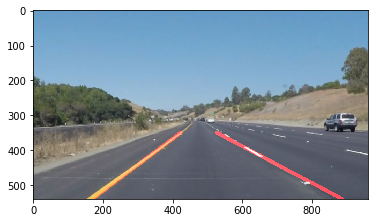

In [14]:
# Draw piped lines on the original colored image
piped_color_image = cv2.addWeighted(image, 1, piped_image, 2, 0) 
plt.imshow(piped_color_image)

In [15]:
############################ OLD METHOD ############################

# Separate line segments between left and right lanes
line_right = np.zeros((1,4),dtype=int)
line_left = np.zeros((1,4),dtype=int)
for line in lines:
    for x1,y1,x2,y2 in line:
        if (y2-y1)/(x2-x1) >= 0:
            line_right = np.concatenate((line_right,line),axis=0)
        else:
            line_left = np.concatenate((line_left,line),axis=0)
line_right = np.delete(line_right,0,0)
line_left = np.delete(line_left,0,0)
print(line_right)
print(line_left)

# Right lane coordinates
max = np.amax(line_right,axis=0)
print(max)
line_right_x1 = np.amax([max[0],max[2]])
print(line_right_x1)
line_right_y1 = np.amax([max[1],max[3]])
print(line_right_y1)
min = np.amin(line_right,axis=0)
print(min)
line_right_x2 = np.amin([min[0],min[2]])
print(line_right_x2)
line_right_y2 = np.amin([min[1],min[3]])
print(line_right_y2)

# Left lane coordinates
max = np.amax(line_left,axis=0)
print(max)
line_left_x2 = np.amax([max[0],max[2]])
print(line_left_x2)
line_left_y1 = np.amax([max[1],max[3]])
print(line_left_y1)
min = np.amin(line_left,axis=0)
print(min)
line_left_x1 = np.amin([min[0],min[2]])
print(line_left_x1)
line_left_y2 = np.amin([min[1],min[3]])
print(line_left_y2)

#####################################################################

[[618 395 658 417]
 [605 393 652 419]]
[[175 539 427 350]
 [262 463 418 353]
 [307 441 428 350]
 [174 538 287 454]
 [297 439 388 375]
 [175 538 302 443]
 [394 369 422 350]
 [289 454 349 409]
 [268 459 294 441]]
[618 395 658 419]
658
419
[605 393 652 417]
605
393
[394 539 428 454]
428
539
[174 369 287 350]
174
350
